### Imports and Data Organization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from warnings import simplefilter

In [2]:
simplefilter("ignore")

In [3]:
df = pd.read_csv('us-counties.csv', index_col='date', parse_dates=True)[['cases']].groupby('date').sum()

In [4]:
df.head()

,cases
date,
2020-01-21,1
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,3


In [43]:
plt.rc("figure", autolayout=True, figsize=(12, 5))

### Exploration

<AxesSubplot:xlabel='date'>

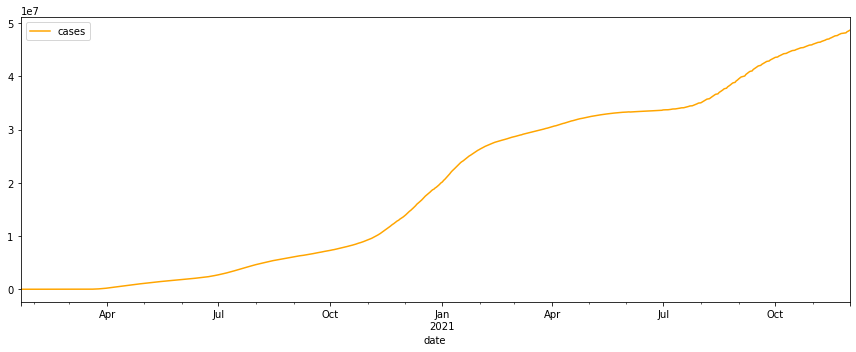

In [44]:
df.plot(color='orange')

### Moving Average Plots

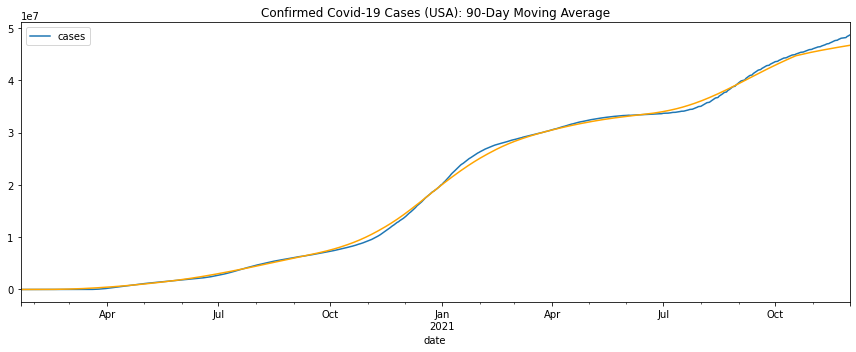

In [45]:
moving_average = df['cases'].rolling(
    window=90,       
    center=True,      
    min_periods=45,  
).mean()              

ax = df.plot()
moving_average.plot(ax=ax, title="Confirmed Covid-19 Cases (USA): 90-Day Moving Average", figsize=[12,5], color="orange")
plt.show()

### Test and Train Sets

In [16]:
n = int(len(df)*.85)
train = df[:n]
test = df[n:]

n, len(df)-n

(578, 103)

In [18]:
train

,cases
date,
2020-01-21,1
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,3
...,...
2021-08-16,36989377
2021-08-17,37133674
2021-08-18,37298543


### Linear Regression

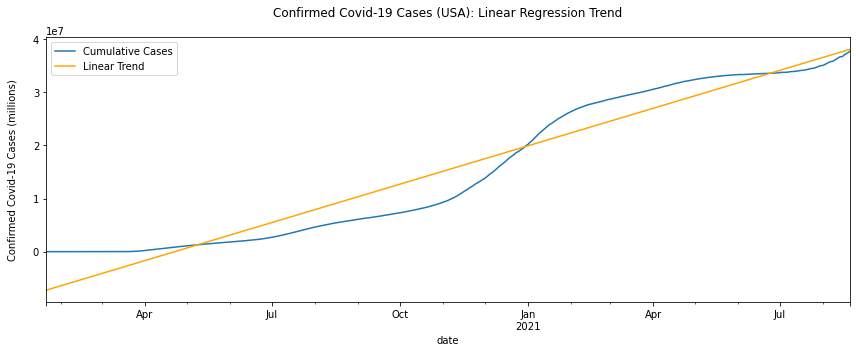

In [46]:
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

dp = DeterministicProcess(
    index=train.index,  
    constant=True,       
    order=1,        
    drop=True,           
)

X = dp.in_sample()

y = train["cases"]  

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = train['cases'].plot(title=f"Confirmed Covid-19 Cases (USA): Linear Regression Trend\n", label='Cumulative Cases', legend=True)
y_pred.plot(ax=ax, label="Linear Trend", figsize=[12,5], color='orange', legend=True, ylabel=f'Confirmed Covid-19 Cases (millions)\n')
plt.show()

In [39]:
pred_X = dp.out_of_sample(steps=len(test.cases),forecast_index=test.index)
y_fore = pd.Series(model.predict(pred_X), index=test.index)
test['linear_pred'] = y_fore

,cases,linear_pred
date,,
2021-08-21,37737034,3.812257e+07
2021-08-22,37777607,3.820105e+07
2021-08-23,38043754,3.827954e+07
2021-08-24,38193951,3.835803e+07
2021-08-25,38364887,3.843651e+07
...,...,...
2021-11-27,48171232,4.581412e+07
2021-11-28,48195182,4.589260e+07
2021-11-29,48411494,4.597109e+07


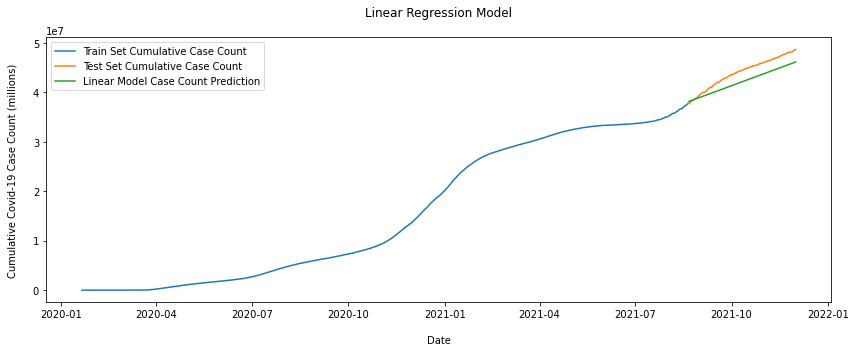

In [78]:
plt.plot(train.cases, label='Train Set Cumulative Case Count')
plt.plot(test.cases, label='Test Set Cumulative Case Count')
plt.plot(test.linear_pred, label='Linear Model Case Count Prediction')
plt.legend()
plt.title('Linear Regression Model\n')
plt.xlabel('\nDate')
plt.ylabel('Cumulative Covid-19 Case Count (millions)\n')
plt.show()

In [50]:
from sklearn.metrics import r2_score
r2_score(test.cases, test.linear_pred)

0.5643791578691817

### ARIMA Model

In [30]:
from pmdarima.arima import ADFTest

adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df)

(0.01, False)

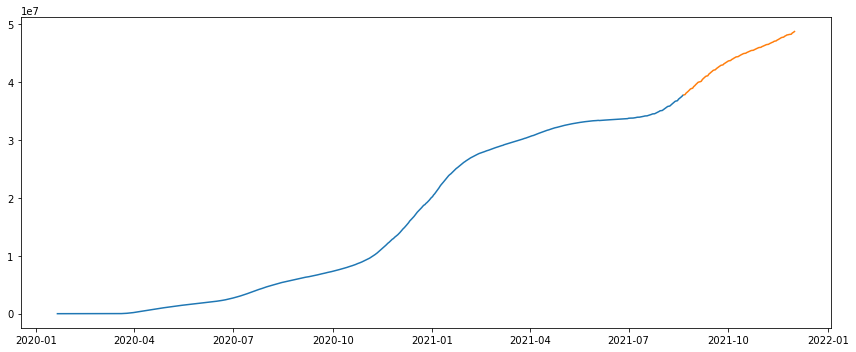

In [32]:
plt.plot(train)
plt.plot(test)
plt.show()

In [82]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       
                      max_p=3, max_q=3,
                      seasonal=False, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      alpha=0.05)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=21105.234, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=14311.834, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=14158.486, Time=0.39 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=20585.607, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=14139.777, Time=0.54 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=20566.676, Time=0.14 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.86 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=14087.456, Time=0.59 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=20070.295, Time=0.52 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=14135.614, Time=0.62 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=13144.9

In [83]:
prediction = pd.DataFrame(data={'date': test.index, 'pred_cases': model.predict(n_periods=(len(df)-n))}).set_index('date', drop=True)
prediction

,pred_cases
date,
2021-08-21,3.783812e+07
2021-08-22,3.799676e+07
2021-08-23,3.817205e+07
2021-08-24,3.833313e+07
2021-08-25,3.850472e+07
...,...
2021-11-27,5.140343e+07
2021-11-28,5.150598e+07
2021-11-29,5.160771e+07


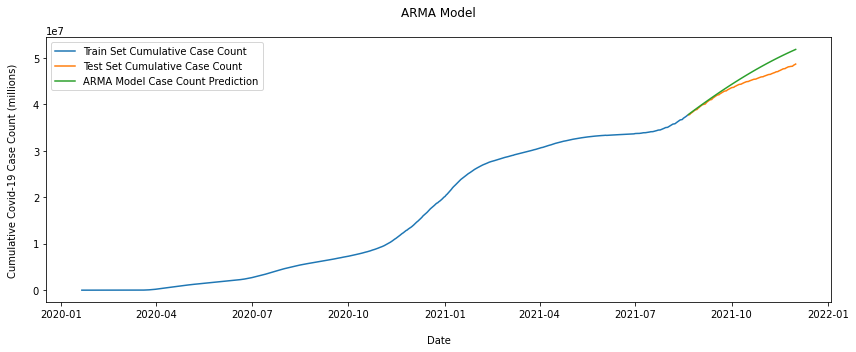

In [85]:
plt.plot(train.cases, label='Train Set Cumulative Case Count')
plt.plot(test.cases, label='Test Set Cumulative Case Count')
plt.plot(prediction.pred_cases, label='ARMA Model Case Count Prediction')
plt.legend()
plt.title('ARMA Model\n')
plt.xlabel('\nDate')
plt.ylabel('Cumulative Covid-19 Case Count (millions)\n')
plt.show()

In [36]:
from sklearn.metrics import r2_score
test['pred_cases'] = prediction
r2_score(test.cases, test.pred_cases)

0.634742750381655